In [266]:
# I.
# -*- coding: utf-8 -*-

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as path_effects
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pandas as pd
import geopandas as gpd
import numpy as np
import re

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [268]:
# II- Download the reference tables

lands = pd.read_csv('/home/hmdg/Documents/Data_Science/Repos/Lands/data/ldown_c.csv')
countries_ref = pd.read_csv('/home/hmdg/Documents/Data_Science/Repos/Lands/data/countries_ref.csv')
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [270]:
# III Merging the tables

# It's neccessary to merge the databases of lands(lands types) and world (geographic reference), 
# using countries_ref as a reference table, to obtain the main df with all the necessary data.

##########################################################
# The study is done just whith the data of the 2016 year #
##########################################################
lands = lands[lands.year==2016]

# Merge the three tables:
l_c = countries_ref.merge(lands,left_on='name_l', right_on='country')
w_l_c = world.merge(l_c,
                    left_on = world['name'].str.strip().str.lower(), 
                    right_on=l_c['name_w'].str.strip().str.lower()).drop(columns=['name', 'key_0'], axis=1)


# Replace the string of types in order of simplify their names
lrep = {'Land area (thousand hectares)':'LA',
        'Arable land (thousand hectares)': 'AL', 'Arable land (% of total land area)':'AL_%',
        'Forest cover (thousand hectares)':'FC', 'Forest cover (% of total land area)':'FC_%',
        'Permanent crops (thousand hectares)':'PC','Permanent crops (% of total land area)':'PC_%',
        'Important sites for terrestrial biodiversity protected (% of total sites protected)':'IB%'}

# Main df with al the data            
w_l_c['type'] = w_l_c['type'].map(lrep)

# IV
# Creating the dataframe to calcule the main indicators
AL = w_l_c[['name_l','name_w','pop_est','value', 'geometry', 'continent']][w_l_c['type']=='AL'].rename(columns={'value':'AL'}).reset_index(drop=True)
PC = w_l_c[['value']][w_l_c['type']=='PC'].rename(columns={'value':'PC'}).reset_index(drop=True)
LA = w_l_c[['value']][w_l_c['type']=='LA'].rename(columns={'value':'LA'}).reset_index(drop=True)

w_land = pd.concat([AL, PC, LA], axis=1, join='inner')

for name in ('name_w','name_l'):
    w_land[name] = w_land[name].str.strip()
    #w_land['name_l'] = w_land['name_l'].str.strip()


def noNaN(df,values):
    for v in values:
        df[values] = df[values].replace(np.nan, 0)
        return df[values]

noNaN(w_land,['AL','PC','LA'])

# V
# Creating the indicators:
# CL, CL%(AL + PC), 'pop_est%', 'density' and 'density_CL', HpF, ref, ind
w_land['CL']= w_land['AL']+w_land['PC']
w_land['CL%']= 100*w_land['CL']/w_land['LA']
w_land['pop_est%'] = 100* w_land['pop_est']/w_land['pop_est'].sum()
w_land['density'] = (w_land['pop_est']/4)/(0.1 + w_land['LA']*1000)
w_land['density_CL'] = (w_land['pop_est']/4)/(0.1+w_land['CL']*1000)

ref_val = 1 #---->> Ha Reference Value!!!!

w_land['HpF'] = (4000) * w_land['CL']/w_land['pop_est']
w_land['ref'] = w_land['HpF'] - ref_val
w_land = w_land.sort_values(by=['continent', 'ref']).reset_index(drop=True)
w_land['name_l']= w_land['name_l'].str.capitalize()
w_land['ind'] = w_land['HpF'].apply(lambda x: 'over' if x >=ref_val else 'under')

## Exceptions:
w_land = w_land[~w_land['name_w'].str.contains('falkland is.|n. cyprus')] 


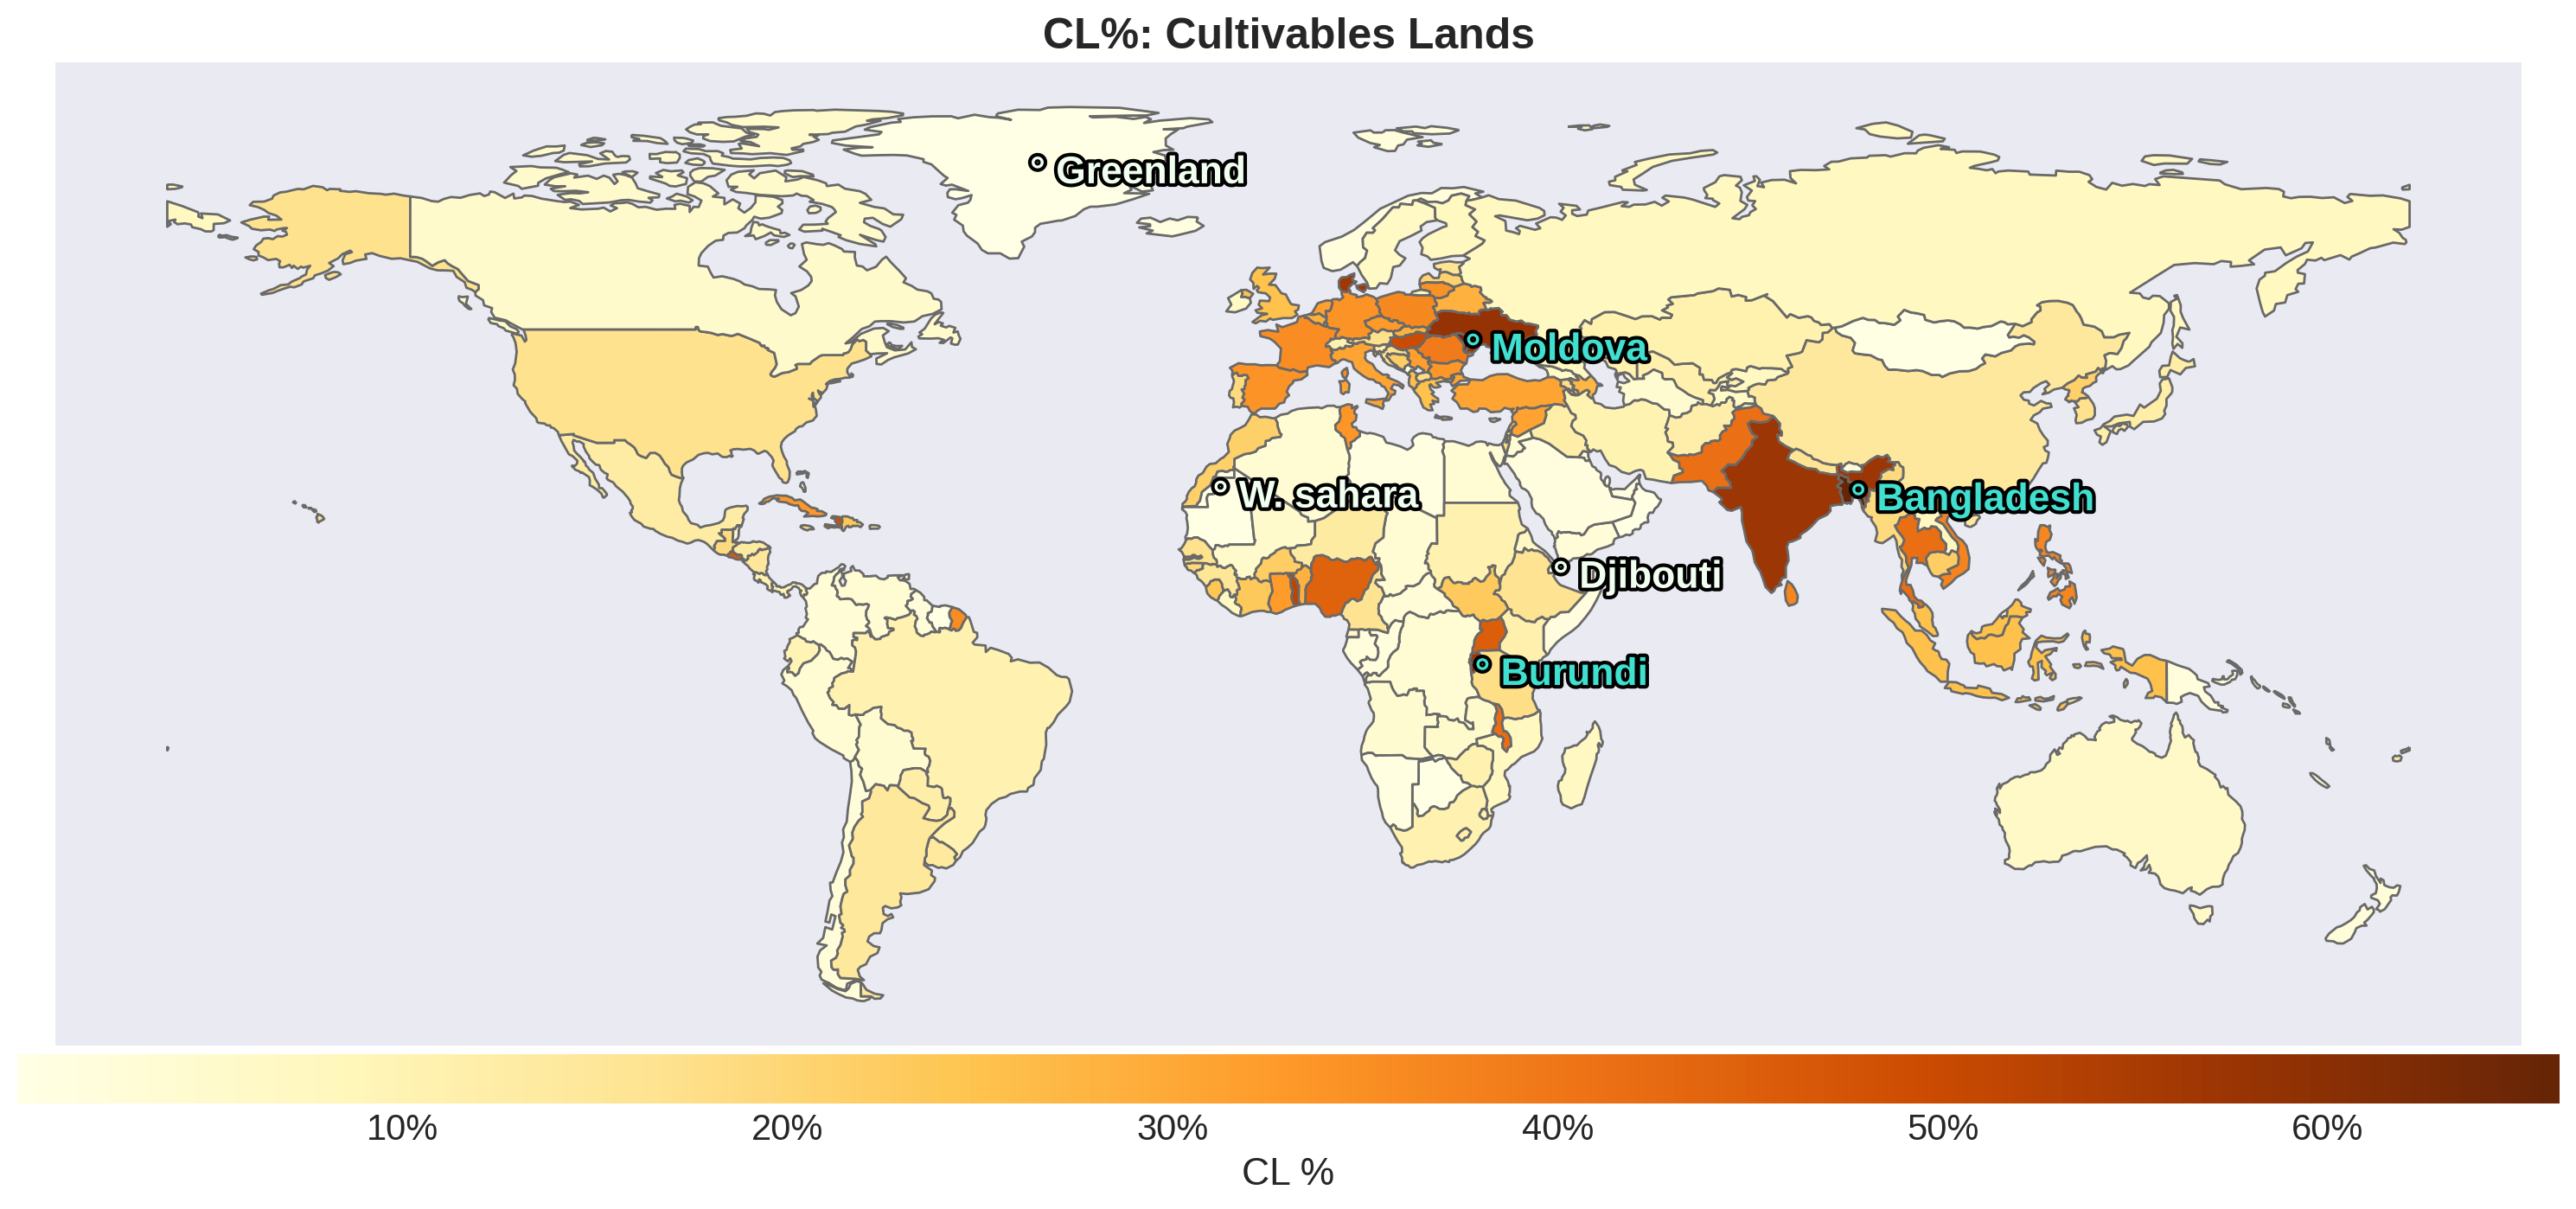

In [271]:
# VII
%matplotlib inline
plt.style.use('seaborn-deep')
plt.rcParams.update({'xtick.labelsize':15, 
                     'ytick.labelsize':15,
                     'ytick.labelleft':'off',
                     'ytick.labelright':'off',
                     'xtick.labelbottom':'off',
                     'axes.spines.left': False,
                     'axes.spines.bottom' : False,
                     'axes.spines.top': False,
                     'axes.spines.right':False,
                     'ytick.left':False,
                     'xtick.bottom':False,
                     'axes.labelsize':16,
                     'axes.grid':False,
                     'axes.edgecolor':'slategrey'
                    })

fig, ax1 = plt.subplots(1, 1, figsize=(15, 10), dpi=200)

divider = make_axes_locatable(ax1)

# Legend bar
cax = divider.append_axes("bottom", size="5%", pad=0.05)

# Plot
ax1 = w_land.plot(column='CL%',
                ax=ax1,
                legend=True,
                edgecolor='dimgray',
                cmap = 'YlOrBr',
                cax=cax,
                legend_kwds={'label': "CL %",
                             'orientation': 'horizontal'}
                 )

# Adding the percentage to the labels of the legend
s = cax.get_xticks()
labelc = []
[labelc.append(str(int(s[n]))+'%') for n in range(len(s))]
cax.set_xticklabels(labelc)

# Selecting the countries to show
dclwmn = pd.concat([w_land.sort_values(by='CL%').tail(3), w_land.sort_values(by='CL%').head(3)]).reset_index(drop=True)


dclwmn['geops'] = gpd.GeoDataFrame(
    geometry = gpd.points_from_xy(dclwmn['geometry'].centroid.x, dclwmn['geometry'].centroid.y),
    crs = "EPSG:4326"
    )

# Adding the names of the selected countries
for place in range(dclwmn.shape[0]):
    if place < 3:
        color = 'turquoise' 
    else:
        color = 'honeydew'
    ax1.text(dclwmn.geops[place].x,
             dclwmn.geops[place].y-3,
             '\u00B0' + ' ' + dclwmn.loc[place,'name_w'].capitalize(),
             fontsize = 16,
             fontweight = 'bold',
             color = color,
             path_effects=[path_effects.Stroke(linewidth=3, foreground='black'),
                       path_effects.Normal()])
    

ax1.set_title('CL%: Cultivables Lands', fontsize=18, fontweight = 'bold')
plt.tight_layout()
plt.savefig('/home/hmdg/Documents/Data_Science/Repos/Lands/images/CL_.png', bbox_inches='tight')

plt.show()
